Read in data and check fields, data types, check for any errors, count number of drill holes and how much data is classified vs unclassified.

In [176]:
import pandas as pd

df = pd.read_csv("data_for_distribution.csv")

num_drill_holes = df['holeid'].nunique()

classified_count = df[df['Class'].isin(['A', 'B'])].shape[0]
unclassified_count = df[~df['Class'].isin(['A', 'B'])].shape[0]

print("Drill holes:", num_drill_holes)
print("Classified Data:",classified_count)
print("Unclassified Data:",unclassified_count)
print(df.head())
print(df.dtypes)
print(df.shape)

Drill holes: 140
Classified Data: 4004
Unclassified Data: 767
  Unique_ID    holeid  from     to  As        Au       Pb       Fe        Mo  \
0    A04812  SOLVE003   561  571.0 NaN     0.066  1031.00  61380.0  138.2000   
1    A03356  SOLVE003   571  581.0 NaN     0.152  1982.00  50860.0   75.4000   
2    A04764  SOLVE003   581  591.0 NaN     0.068  1064.80  57940.0   29.2000   
3    A04626  SOLVE003   591  601.0 NaN     0.074   891.60  48620.0   63.0000   
4    A05579  SOLVE003   601  611.0 NaN  0.043125   801.25  51025.0   56.0625   

      Cu          S       Zn Class  
0  3.600  3586.0000  43.6000     A  
1  4.800  1822.0000  36.4000     A  
2  3.000   740.4000  36.6000     A  
3  4.200   820.8000  39.6000     A  
4  4.875   745.6875  32.3125     A  
Unique_ID     object
holeid        object
from           int64
to           float64
As           float64
Au            object
Pb           float64
Fe           float64
Mo           float64
Cu           float64
S            float64
Zn  

No collar locations, No grade units, some missing data, only selected intervals of data for each drill hole, Au contains string '<0.005' convert to number half detection limit 0.0025. Au is an object field change to float64.

In [177]:
df['Au'] = df['Au'].replace('<0.005', 0.0025)
df['Au'] = pd.to_numeric(df['Au'], errors='coerce')
df['Au'] = df['Au'].astype('float64')

Check for outliers / errors

In [178]:
print("As:", df['As'].min(), "-", df['As'].max())
print("Au:", df['Au'].min(), "-", df['Au'].max())
print("Pb:", df['Pb'].min(), "-", df['Pb'].max())
print("Fe:", df['Fe'].min(), "-", df['Fe'].max())
print("Mo:", df['Mo'].min(), "-", df['Mo'].max())
print("Cu:", df['Cu'].min(), "-", df['Cu'].max())
print("S:",  df['S'].min(),  "-", df['S'].max())
print("Zn:", df['Zn'].min(), "-", df['Zn'].max())

As: 1.0 - 827.8
Au: 0.0025 - 1.878
Pb: 1.6 - 29793.8
Fe: 2080.0 - 397000.0
Mo: -999.0 - 1939.4
Cu: 1.0 - 6767.0
S: 26.0 - 217600.0
Zn: 5.6 - 3455.0


Remove all -999 values

In [179]:
df = df[~(df == -999).any(axis=1)]

In [180]:
print(df)

     Unique_ID    holeid  from      to    As        Au       Pb       Fe  \
0       A04812  SOLVE003   561   571.0   NaN  0.066000  1031.00  61380.0   
1       A03356  SOLVE003   571   581.0   NaN  0.152000  1982.00  50860.0   
2       A04764  SOLVE003   581   591.0   NaN  0.068000  1064.80  57940.0   
3       A04626  SOLVE003   591   601.0   NaN  0.074000   891.60  48620.0   
4       A05579  SOLVE003   601   611.0   NaN  0.043125   801.25  51025.0   
...        ...       ...   ...     ...   ...       ...      ...      ...   
4766    A06258  SOLVE291  1281  1291.0   9.0  0.030000    74.80  53460.0   
4767    A04915  SOLVE291  1291  1301.0  12.2  0.064000   208.20  51500.0   
4768    A06596  SOLVE291  1301  1311.0  10.4  0.024000   145.40  55040.0   
4769    A07560  SOLVE291  1311  1321.0  10.0  0.011000   109.60  55460.0   
4770    A07802  SOLVE291  1321  1331.0   5.0  0.009000    69.20  42520.0   

            Mo     Cu          S       Zn Class  
0     138.2000  3.600  3586.0000  43.

Visualise the data

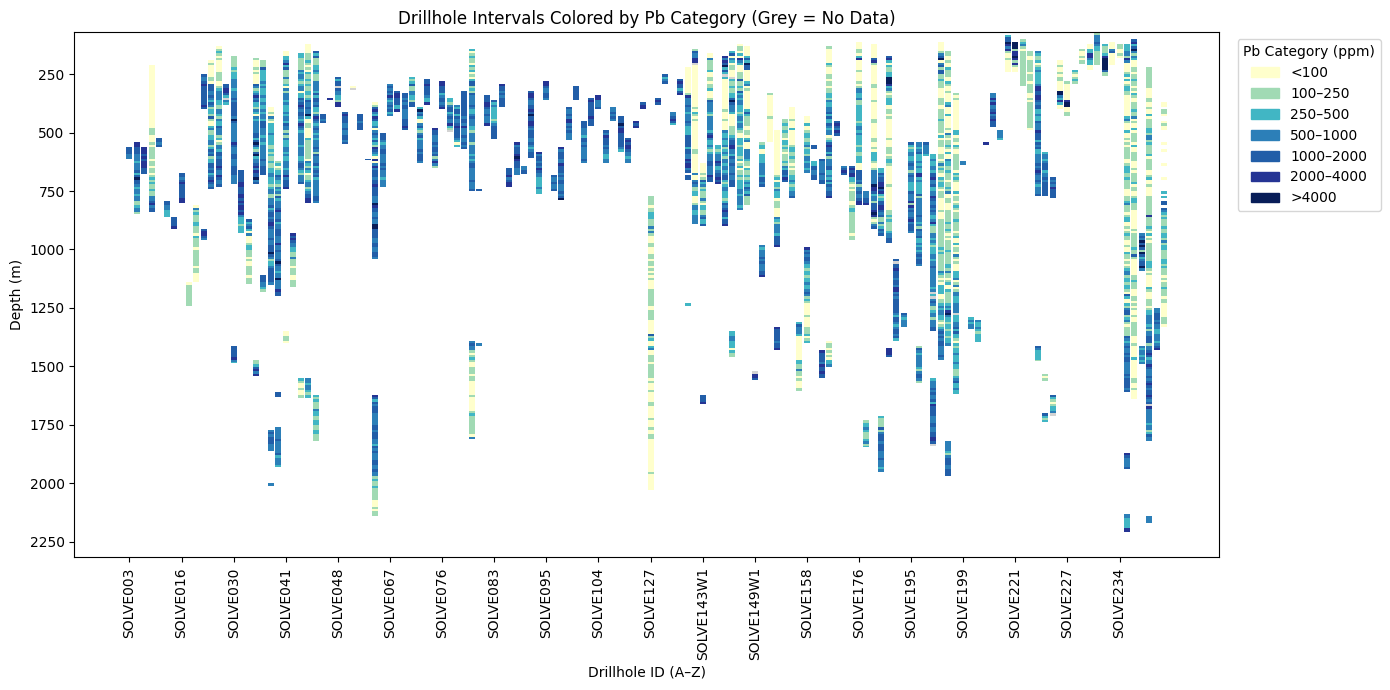

(4743, 15)


In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Ensure Pb is numeric
df['Pb'] = pd.to_numeric(df['Pb'], errors='coerce')

# Define Pb bins and labels
pb_bins = [0, 100, 250, 500, 1000, 2000, 4000, df['Pb'].max()]
pb_labels = ["<100", "100–250", "250–500", "500–1000", "1000–2000", "2000–4000", ">4000"]
colors_list = ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#225ea8', '#253494', '#081d58']

# Categorize Pb
df['Pb_category'] = pd.cut(df['Pb'], bins=pb_bins, labels=pb_labels, include_lowest=True)

# Map each category to a color
category_to_color = dict(zip(pb_labels, colors_list))

# Sort holes and assign x position
hole_order = pd.Series(df['holeid'].unique()).sort_values()
holeid_to_x = {holeid: i for i, holeid in enumerate(hole_order)}
df['x_pos'] = df['holeid'].map(holeid_to_x)

# Start plot
plt.figure(figsize=(14, 7))

for _, row in df.iterrows():
    x = row['x_pos']
    height = row['to'] - row['from']
    bottom = row['from']
    category = row['Pb_category']
    
    color = 'lightgrey' if pd.isna(category) else category_to_color[category]
    
    plt.bar(
        x=x,
        height=height,
        bottom=bottom,
        width=0.8,
        color=color,
        linewidth=0,
        alpha=1.0
    )

# Invert Y-axis
plt.gca().invert_yaxis()

# Custom legend
patches = [mpatches.Patch(color=color, label=label) for label, color in category_to_color.items()]
plt.legend(handles=patches, title='Pb Category (ppm)', bbox_to_anchor=(1.01, 1), loc='upper left')

# X-axis labels
xticks = list(holeid_to_x.values())
xlabels = list(holeid_to_x.keys())
step = max(1, len(xticks) // 20)
plt.xticks(ticks=xticks[::step], labels=xlabels[::step], rotation=90)

# Labels and layout
plt.xlabel('Drillhole ID (A–Z)')
plt.ylabel('Depth (m)')
plt.title("Drillhole Intervals Colored by Pb Category (Grey = No Data)")
plt.tight_layout()
plt.show()
print(df.shape)


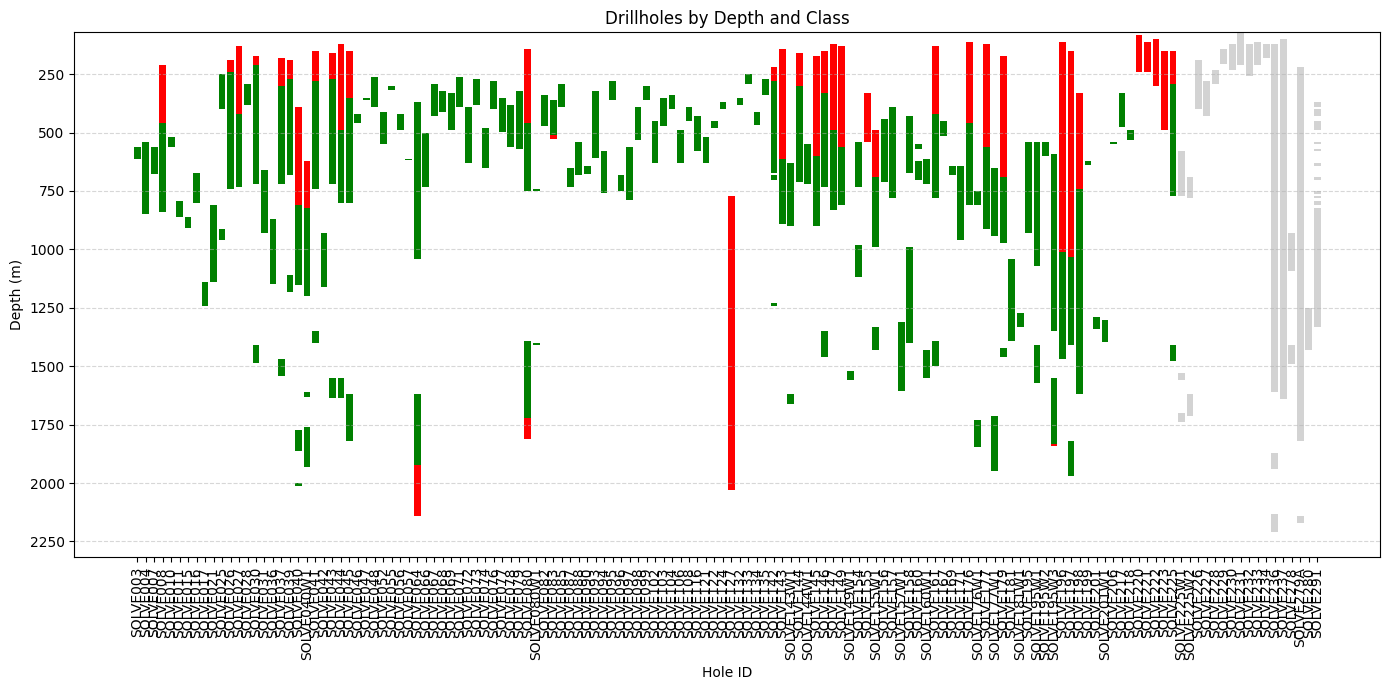

(4743, 15)


In [182]:
# Define custom class colors
class_colors = {
    'A': 'green',
    'B': 'red'
}

# Create vertical bar plot
plt.figure(figsize=(14, 7))

for _, row in df.iterrows():
    x = row['holeid']
    top = row['from']
    bottom = row['to']
    cls = row['Class']
    color = class_colors.get(cls, 'lightgrey')

    plt.bar(
        x=x,
        height=bottom - top,
        bottom=top,
        width=0.8,
        color=color,
        # edgecolor='black'
    )

plt.ylabel("Depth (m)")
plt.xlabel("Hole ID")
plt.title("Drillholes by Depth and Class")
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
print(df.shape)


In [183]:
# Encode the class as numeric for correlation
df_train = df[df['Class'].isin(['A', 'B'])].copy()
df_train['Class_numeric'] = df_train['Class'].map({'A': 1, 'B': 0})

# Select numeric element columns
element_cols = ['As', 'Au', 'Pb', 'Fe', 'Mo', 'Cu', 'S', 'Zn']
df_train[element_cols] = df_train[element_cols].apply(pd.to_numeric, errors='coerce')

# Compute correlation between each element and the numeric class
correlations = df_train[element_cols + ['Class_numeric']].corr()['Class_numeric'].drop('Class_numeric')

print(correlations.sort_values(ascending=False))
print(df.shape)
print(df_train.shape)

Pb    0.246534
Mo    0.183762
Au    0.167806
Fe    0.067008
Cu    0.029125
Zn    0.003470
S    -0.012251
As   -0.319433
Name: Class_numeric, dtype: float64
(4743, 15)
(4004, 16)


Pb cutt-off only

Best Pb Cut-off: 160.0
Best Accuracy: 0.784


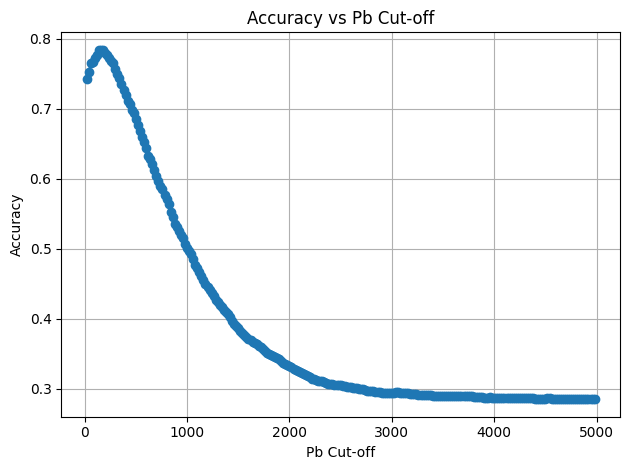

(4743, 16)


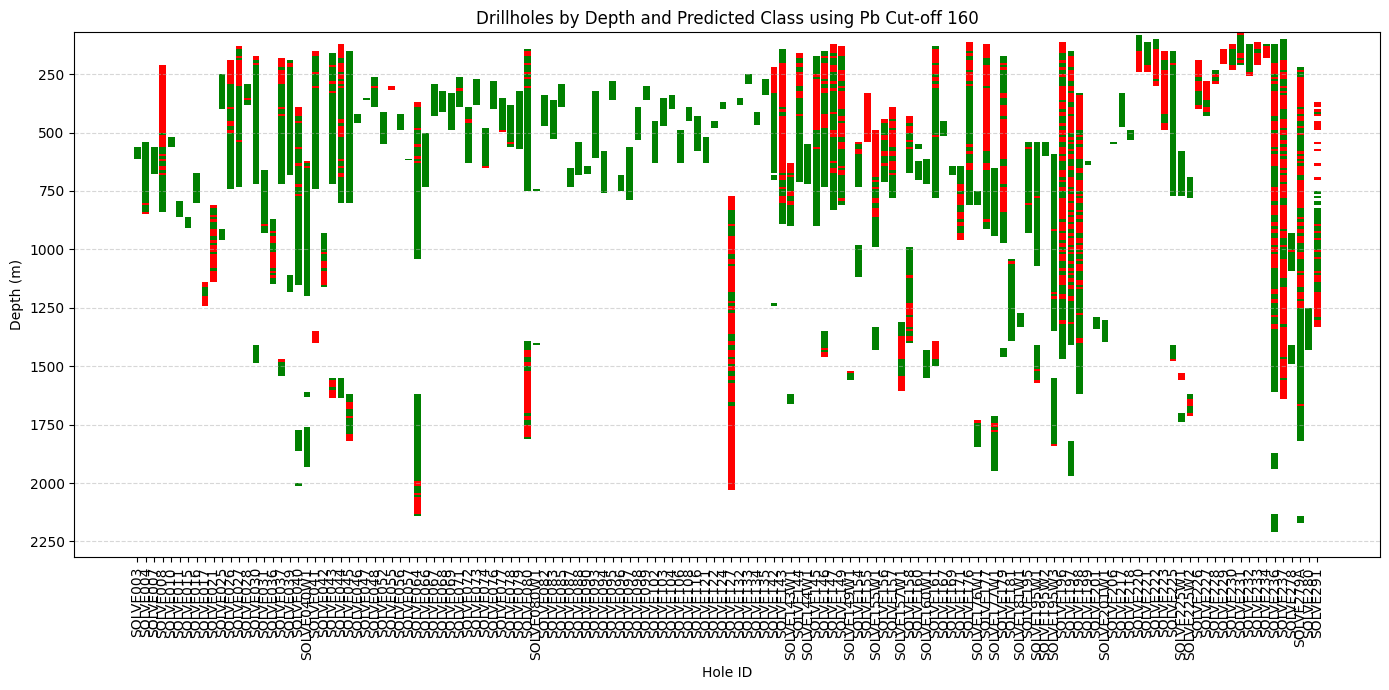

In [184]:
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Range of Pb cut-off values to test
cutoff_range = range(20, 5000, 20)

results = []

for cutoff in cutoff_range:
    df['predicted_pbcutoff'] = df['Pb'].apply(lambda x: 'A' if x >= cutoff else 'B')
    mask_known = df['Class'].isin(['A', 'B'])
    accuracy = accuracy_score(df.loc[mask_known, 'Class'], df.loc[mask_known, 'predicted_pbcutoff'])
    results.append((cutoff, accuracy))

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=['Pb_cutoff', 'Accuracy'])

# Find best cutoff
best_row = results_df.loc[results_df['Accuracy'].idxmax()]
best_cutoff = best_row['Pb_cutoff']

print("Best Pb Cut-off:", best_cutoff)
print("Best Accuracy:", round(best_row['Accuracy'], 4))

# Plot accuracy vs cutoff
plt.plot(results_df['Pb_cutoff'], results_df['Accuracy'], marker='o')
plt.xlabel("Pb Cut-off")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Pb Cut-off")
plt.grid(True)
plt.tight_layout()
plt.show()

# Apply best cutoff to assign predicted_pbcutoff
df['predicted_pbcutoff'] = df['Pb'].apply(lambda x: 'A' if x >= best_cutoff else 'B')

# Export with final predictions
print(df.shape)
df.to_csv('predicted_pb_cutoff.csv', index=False)

# Define custom class colors
class_colors = {
    'A': 'green',
    'B': 'red'
}

# Plot drillholes
plt.figure(figsize=(14, 7))

for _, row in df.iterrows():
    x = row['holeid']
    top = row['from']
    bottom = row['to']
    cls = row['predicted_pbcutoff']
    color = class_colors.get(cls, 'lightgrey')

    plt.bar(
        x=x,
        height=bottom - top,
        bottom=top,
        width=0.8,
        color=color
    )

plt.ylabel("Depth (m)")
plt.xlabel("Hole ID")
plt.title("Drillholes by Depth and Predicted Class using Pb Cut-off 160")
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Weighted Scoring using Pb, As, Mo and Au as the others had insignificant correlation

Best threshold: 47.2774
Best accuracy: 0.7891


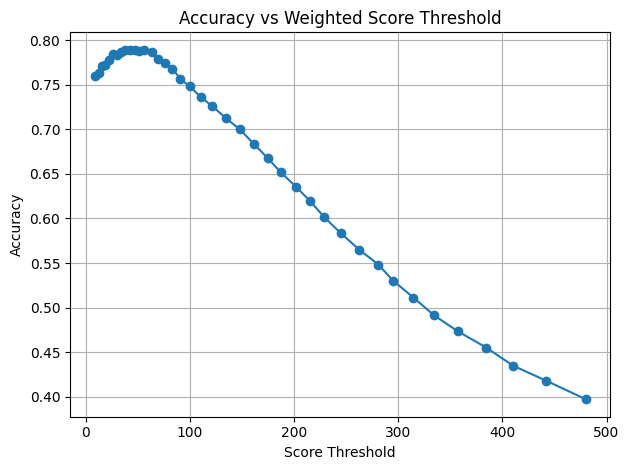

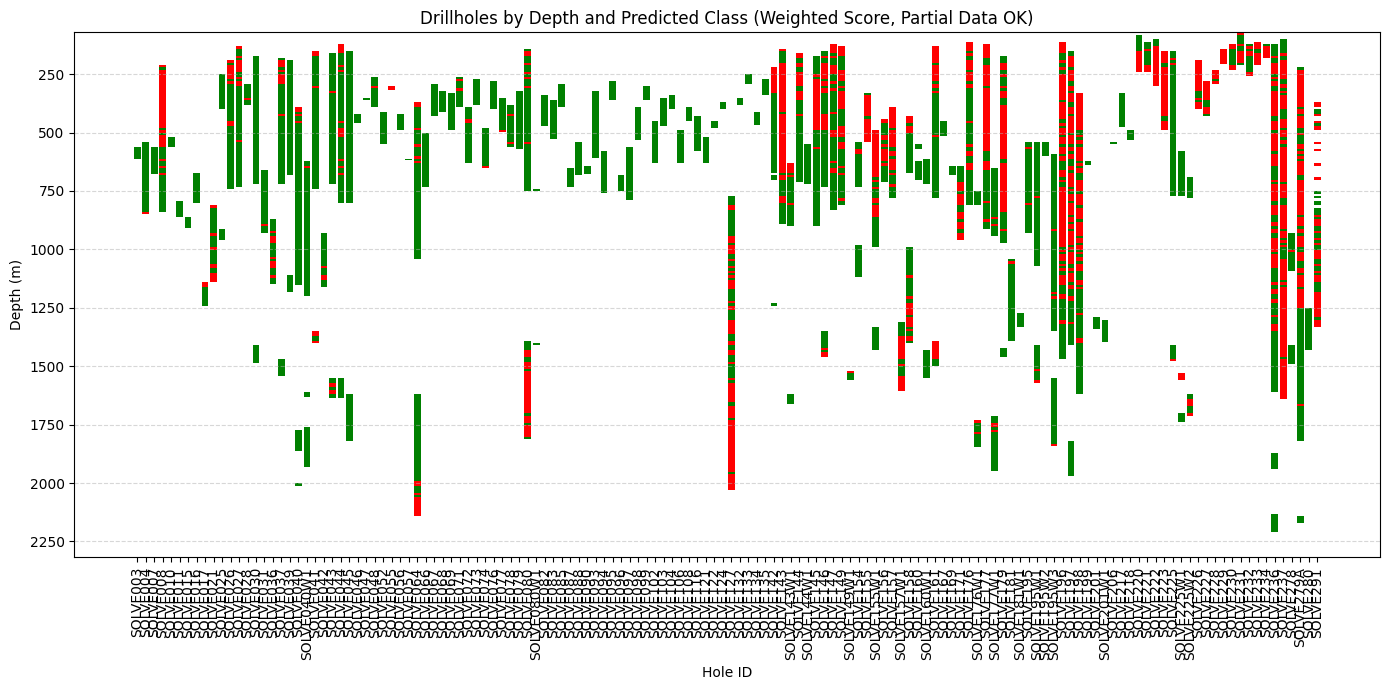

(4743, 28)


In [195]:
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define class colors
class_colors = {
    'A': 'green',
    'B': 'red'
}

# Convert input fields to numeric
for col in ['Pb', 'Mo', 'Au', 'As']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Correlation weights
# weights = {'Pb': 0.29, 'Mo': 0.18, 'Au': 0.16, 'As': -0.22}
weights = {'Pb': 0.246, 'Mo': 0.18, 'Au': 0.16, 'As': -0.31}

# Function to compute weighted score row-wise, skipping NaNs
def compute_weighted_score(row):
    w_sum = 0
    s_sum = 0
    for col, weight in weights.items():
        if pd.notna(row[col]):
            w_sum += abs(weight)
            s_sum += row[col] * weight
    return s_sum / w_sum if w_sum else None

df['score'] = df.apply(compute_weighted_score, axis=1)

# Drop only rows with no usable score
valid_scores = df.dropna(subset=['score']).copy()

# Define candidate thresholds
thresholds = sorted(valid_scores['score'].quantile(q) for q in [x / 100 for x in range(10, 90, 2)])

results = []

# Evaluate threshold performance
for t in thresholds:
    df['predicted_weights'] = df['score'].apply(lambda x: 'A' if pd.notna(x) and x >= t else 'B')
    known = df['Class'].isin(['A', 'B']) & df['score'].notna()
    accuracy = accuracy_score(df.loc[known, 'Class'], df.loc[known, 'predicted_weights'])
    results.append((t, accuracy))

# Best threshold
results_df = pd.DataFrame(results, columns=['Threshold', 'Accuracy'])
best = results_df.loc[results_df['Accuracy'].idxmax()]
best_threshold = best['Threshold']

print("Best threshold:", round(best_threshold, 4))
print("Best accuracy:", round(best['Accuracy'], 4))

# Apply final prediction
df['predicted_weights'] = df['score'].apply(lambda x: 'A' if pd.notna(x) and x >= best_threshold else 'B')

# Save results
df.to_csv("predicted_weights.csv", index=False)

# Plot threshold vs accuracy
plt.plot(results_df['Threshold'], results_df['Accuracy'], marker='o')
plt.xlabel("Score Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Weighted Score Threshold")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot drillholes
plt.figure(figsize=(14, 7))

for _, row in df.iterrows():
    x = row['holeid']
    top = row['from']
    bottom = row['to']
    cls = row['predicted_weights']
    color = class_colors.get(cls, 'lightgrey')

    plt.bar(
        x=x,
        height=bottom - top,
        bottom=top,
        width=0.8,
        color=color
    )

plt.ylabel("Depth (m)")
plt.xlabel("Hole ID")
plt.title("Drillholes by Depth and Predicted Class (Weighted Score, Partial Data OK)")
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(df.shape)


Machine Learning Model

Accuracy: 0.8452

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.69      0.72       232
           1       0.88      0.91      0.89       569

    accuracy                           0.85       801
   macro avg       0.82      0.80      0.81       801
weighted avg       0.84      0.85      0.84       801



c:\Users\PhilGreville\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:06:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


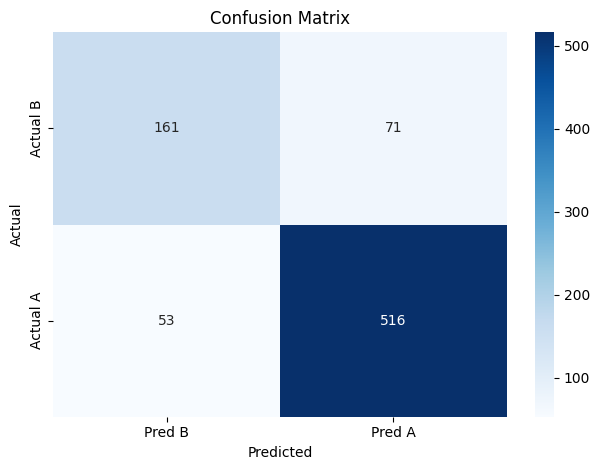

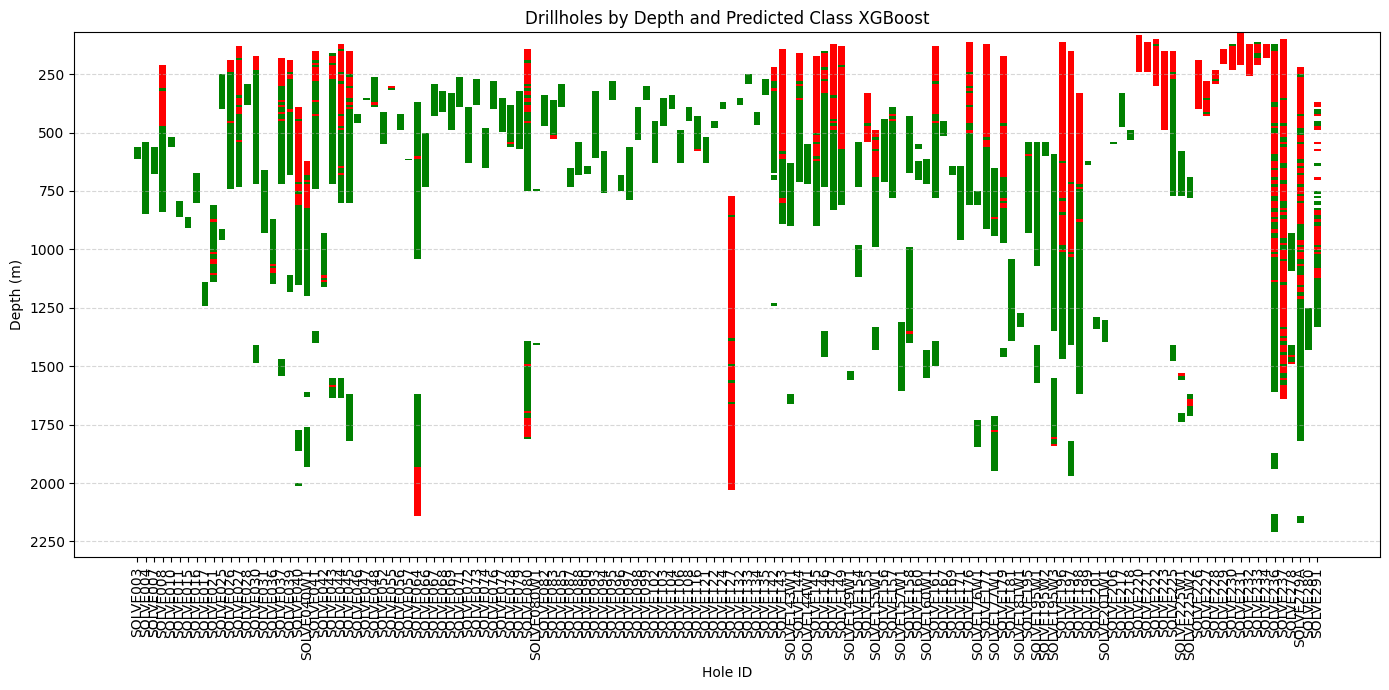

(4743, 19)


In [192]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only rows with known class
df_known = df[df['Class'].isin(['A', 'B'])].copy()

# Features to use
features = ['Pb', 'Mo', 'Au', 'As', 'Fe', 'Cu', 'S', 'Zn']
df_known[features] = df_known[features].apply(pd.to_numeric, errors='coerce')

# Fill missing values with column means
df_known[features] = df_known[features].fillna(df_known[features].mean())

# Encode class
df_known['Class_numeric'] = df_known['Class'].map({'A': 1, 'B': 0})

# Split data
X = df_known[features]
y = df_known['Class_numeric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred B', 'Pred A'],
            yticklabels=['Actual B', 'Actual A'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# --- Apply model to full dataset ---
# Prepare full feature set
df_full = df.copy()
df_full[features] = df_full[features].apply(pd.to_numeric, errors='coerce')
df_full[features] = df_full[features].fillna(df_known[features].mean())

# Predict
predicted_numeric = model.predict(df_full[features])
df_full['predicted_xgboost'] = ['A' if p == 1 else 'B' for p in predicted_numeric]

# Export to CSV
df_full.to_csv("predicted_xgboost.csv", index=False)

# Plot drillholes
plt.figure(figsize=(14, 7))

for _, row in df_full.iterrows():
    x = row['holeid']
    top = row['from']
    bottom = row['to']
    cls = row['predicted_xgboost']
    color = class_colors.get(cls, 'lightgrey')

    plt.bar(
        x=x,
        height=bottom - top,
        bottom=top,
        width=0.8,
        color=color
    )

plt.ylabel("Depth (m)")
plt.xlabel("Hole ID")
plt.title("Drillholes by Depth and Predicted Class XGBoost")
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(df.shape)


Account for depth relationship using XGBoost

Accuracy: 0.9351

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       232
           1       0.95      0.96      0.95       569

    accuracy                           0.94       801
   macro avg       0.92      0.92      0.92       801
weighted avg       0.93      0.94      0.93       801



c:\Users\PhilGreville\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:56:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


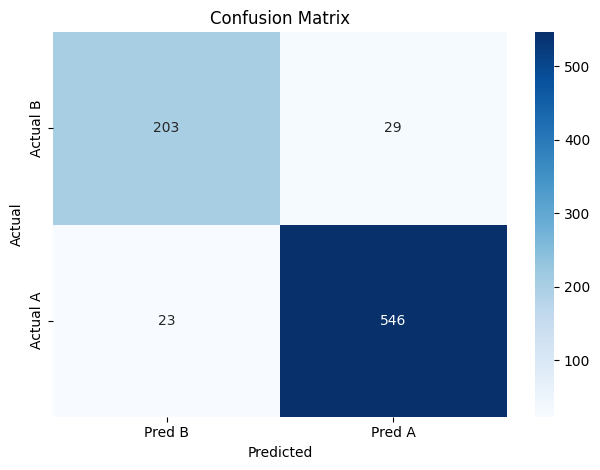

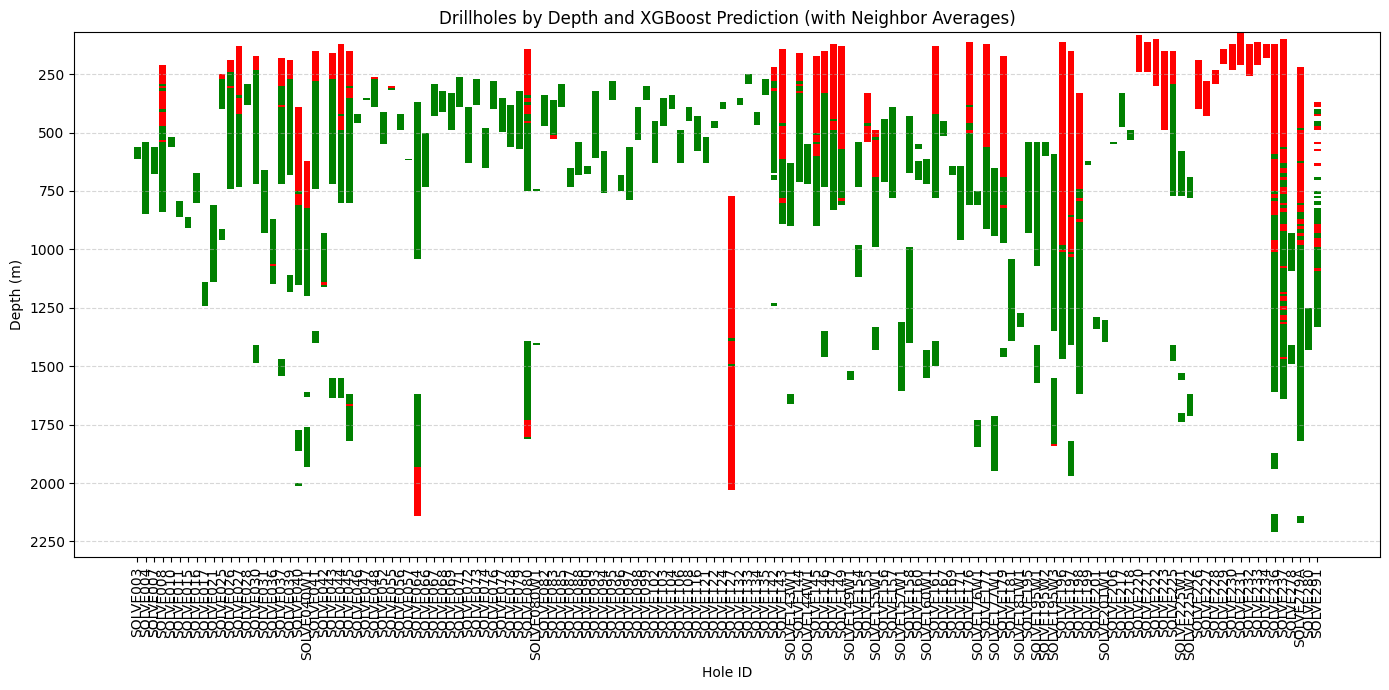

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Define class colors
class_colors = {
    'A': 'green',
    'B': 'red'
}

# Calculate depth midpoint
df['depth_mid'] = (df['from'] + df['to']) / 2

# Convert elements to numeric
elements = ['Pb', 'Mo', 'Au', 'As', 'Fe', 'Cu', 'S', 'Zn']
for col in elements:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Compute neighbor-averaged features ---
for col in elements:
    df[f'{col}_avg3'] = df.groupby('holeid')[col].transform(lambda x: x.rolling(3, min_periods=1, center=True).mean())

# Filter known class data
df_known = df[df['Class'].isin(['A', 'B'])].copy()

# Features: original + neighbor means + depth
features = elements + [f'{col}_avg3' for col in elements] + ['depth_mid']
df_known[features] = df_known[features].fillna(df_known[features].mean())

# Encode class
df_known['Class_numeric'] = df_known['Class'].map({'A': 1, 'B': 0})

# Train-test split
X = df_known[features]
y = df_known['Class_numeric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred B', 'Pred A'],
            yticklabels=['Actual B', 'Actual A'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# --- Predict on full dataset ---
df_full = df.copy()
df_full[features] = df_full[features].fillna(df_known[features].mean())
pred_numeric = model.predict(df_full[features])
df_full['predicted_xgboost_int'] = ['A' if val == 1 else 'B' for val in pred_numeric]

# Export
df_full.to_csv("predicted_depth_intervals.csv", index=False)

# Plot drillholes
plt.figure(figsize=(14, 7))

for _, row in df_full.iterrows():
    x = row['holeid']
    top = row['from']
    bottom = row['to']
    cls = row.get('predicted_xgboost', 'B')
    color = class_colors.get(cls, 'lightgrey')

    plt.bar(
        x=x,
        height=bottom - top,
        bottom=top,
        width=0.8,
        color=color
    )

plt.ylabel("Depth (m)")
plt.xlabel("Hole ID")
plt.title("Drillholes by Depth and XGBoost Prediction (with Neighbor Averages)")
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
